<a href="https://colab.research.google.com/github/sunflowersunflower/recommender_cnn/blob/master/recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
import os
import pickle
import re
from tensorflow.python.ops import math_ops

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1qn0ljk89KlTT46fWIPBuJZZIyoqqB7rz'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('users.dat')  

In [0]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_csv('users.dat', sep='::', header=None, names=users_title, engine = 'python')
users_orig = users.values
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [0]:
link = 'https://drive.google.com/open?id=1Ncz81hNfjBnCta53ntolILKvR-8YcMI0'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('movies.dat')  

In [0]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('movies.dat', sep='::', header=None, names=movies_title, engine='python')
movies_orig = movies.values
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
link = 'https://drive.google.com/open?id=18BohWrf7VGldB53x9Z7HZPlDT11YAa5t'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('ratings.dat')  

In [0]:
ratings_title = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings = pd.read_csv('ratings.dat', sep='::', header=None, names=ratings_title, engine='python')
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# Preprocessing:
not change: userid, occupationid, movieid

gender: F/M ~ 0/1

age: convert to 0-7

genres: vectors

title: vectors

drop: zip-code, timestamp

In [0]:
# convert gender
gender_map = {'F':0, 'M':1}
users.drop(['Zip-code'], axis=1,inplace=True)
users['Gender'] = users['Gender'].map(gender_map)

In [0]:
# convert age
age_map = {val:i for i, val in enumerate(sorted(users['Age'].unique()))}
users['Age'] = users['Age'].map(age_map)

In [0]:
users.head()

,UserID,Gender,Age,OccupationID
0,1,0,0,10
1,2,1,6,16
2,3,1,2,15
3,4,1,4,7
4,5,1,2,20


In [0]:
# remove the year in the title
pattern = re.compile(r'^(.*)\((\d+)\)$') #r表示后面是一个正则表达式''
                                        #^匹配开头,$匹配结尾,(.*)中的()表示匹配其中的任意正则表达式,.匹配任何字符,*代表可以重复0次或多次
                                        #\(和\)：表示对括号的转义，匹配文本中真正的括号
                                        #(\d+)表示匹配()内的任意字符,\d表示任何数字,+代表数字重复一次或者多次
title_map = {val:pattern.match(val).group(1) for i, val in enumerate(movies['Title'].unique())}
movies['Title'] = movies['Title'].map(title_map)

In [0]:
# convert genres
#将电影类型转成等长数字列表，长度是18
genres_set = set()
for val in movies['Genres'].str.split('|'):
    genres_set.update(val) 
genres_set.add('<PAD>')
genres_to_int = {val:i for i, val in enumerate(genres_set)}
genres_map = {val:[genres_to_int[gen] for gen in val.split('|')] for i, val in enumerate(movies['Genres'].unique())}
for key in genres_map:
    for cnt in range(max(genres_to_int.values()) - len(genres_map[key])):
        genres_map[key].insert(len(genres_map[key]) + cnt,genres_to_int['<PAD>'])

In [0]:
movies['Genres'] = movies['Genres'].map(genres_map)

In [0]:
# convert title
title_set = set()
for val in movies['Title'].str.split():
    title_set.update(val) #添加新元素到集合当中，即完成出现电影中的新单词时，存下
title_set.add('<PAD>')
title_to_int = {val:i for i, val in enumerate(title_set)} #对单词像字典一样进行标注'描述电影的word：数字'格式,即数字字典
 
title_count = 15
title_map = {val:[title_to_int[word] for word in val.split()] for i, val in enumerate(movies['Title'].unique())}
                                #val.split()得到全部被空格分开的电影名称字符串列表，row遍历电影集中一个电影的全部单词
                                #title_map得到的是字典，格式为'一个电影字符串：[描述这个电影的全部单词构成的一个对应的数值列表]'

for key in title_map:
    for cnt in range(title_count - len(title_map[key])):
        title_map[key].insert(len(title_map[key]) + cnt,title_to_int['<PAD>'])

In [0]:
movies['Title'] = movies['Title'].map(title_map)

In [0]:
movies.head()

,MovieID,Title,Genres
0,1,"[1415, 3715, 2940, 2940, 2940, 2940, 2940, 294...","[11, 13, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3..."
1,2,"[461, 2940, 2940, 2940, 2940, 2940, 2940, 2940...","[5, 13, 14, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3..."
2,3,"[5185, 1639, 1934, 2940, 2940, 2940, 2940, 294...","[8, 12, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
3,4,"[464, 4362, 792, 2940, 2940, 2940, 2940, 2940,...","[8, 15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
4,5,"[2409, 2489, 3685, 521, 2888, 2597, 2940, 2940...","[8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."


In [0]:
ratings.drop('Timestamp', axis=1, inplace=True)
ratings.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [0]:
# combine data
data = pd.merge(pd.merge(ratings, users), movies)
data.head()

,UserID,MovieID,Rating,Gender,Age,OccupationID,Title,Genres
0,1,1193,5,0,0,10,"[4241, 4165, 3863, 3685, 3405, 4444, 2940, 294...","[15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
1,2,1193,5,1,6,16,"[4241, 4165, 3863, 3685, 3405, 4444, 2940, 294...","[15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
2,12,1193,4,1,2,12,"[4241, 4165, 3863, 3685, 3405, 4444, 2940, 294...","[15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
3,15,1193,4,1,2,7,"[4241, 4165, 3863, 3685, 3405, 4444, 2940, 294...","[15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
4,17,1193,5,1,5,1,"[4241, 4165, 3863, 3685, 3405, 4444, 2940, 294...","[15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."


In [0]:
features_pd = data.drop(['Rating'], axis=1)
targets_pd = data['Rating']

In [0]:
features = features_pd.values
targets_values = targets_pd.values 

In [0]:
    #title_count电影名长度15
    #title_set {索引：去掉年份且不重复的电影名}
    #genres_to_int {题材字符串列表：数字}
    #features 去掉评分ratings列的三表合并信息，作为输入x。则列信息：userid,gender,age,occupation,movieid,title,genres
    #targets_values 评分，学习目标y,三表合并后的对应ratings

In [0]:
def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))

In [0]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
                                      #ndarray.take(indices, axis=None, out=None, mode='raise')从轴axis上获取数组中的元素，并以一维数组或者矩阵返回
                                      #按axis选择处于indices位置上的值
                                      #axis用于选择值的轴，0为横轴，1为纵向选
                                      #如features.take(0,0)就会选择横向第一条数据，(1,0)会选择横向第二条数据
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres_to_int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

In [0]:
print(uid_max, gender_max, age_max, job_max, movie_id_max, movie_categories_max, movie_title_max)

6041 2 7 21 3953 19 5215


In [0]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

In [0]:
def get_inputs():
    #tf.placeholder(dtype, shape=None, name=None)此函数可以理解为形参，用于定义过程，在执行的时候再赋具体的值
    #dtype：数据类型
    #shape：数据形状。默认是None,[行数，列数]
    #name：名称
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")   # 这里一行代表一个用户的id，是batch×1，每一行是一个列表
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")
    
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

# User features 

In [0]:
#定义User的嵌入矩阵，完成原始矩阵经过嵌入层后得到的输出
def get_user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"): #用于后面tensorboard可视化图层关系
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        #tf.random_uniform(shape, minval=0,maxval=None,dtype=tf.float32) 从均匀分布中输出随机值。
        #返回shape形状矩阵：用户数×特征数，产生于low(-1)和high(1)之间，产生的值是均匀分布的。
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
        #tf.nn.embedding_lookup(tensor, id) 选取一个张量tensor里面索引id对应的元素
        #选取uid_embed_matrix的用户id对应的某个用户id的向量, # uid 这里一行代表一个用户的id，是batch×1，每一行是一个列表
    
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name= "gender_embed_matrix") 
                                                                          #这里特征数降一半
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")
                                                                          #选取gender_embed_matrix的用户性别对应的某个用户性别的向量

        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")
        
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

In [0]:
#将User的嵌入矩阵一起全连接生成User的特征
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        #第一层全连接
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu) # 输入为batch*embed_dim
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)  # 输入为batch*embed_dim//2
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)   # 输入为batch*embed_dim//2
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)    # 输入为batch*embed_dim//2

        # tf.layers.dense(inputs,units,activation=None,use_bias=True,kernel_initializer=None,bias_initializer=tf.zeros_initializer(),
                        # kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,
                        # bias_constraint=None,trainable=True,name=None,reuse=None)
                        #inputs:该层的输入; units:输出的大小(维数),整数或long; activation: 使用什么激活函数（神经网络的非线性层），默认为None，不使用激活函数
                        #name该层的名字
        
        #第二层全连接
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
                                                          #     对于三维来说0表示第一个括号维度，1表示第二个括号维度，2表示第三个括号维度
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])  #-1表示缺省值，满足其他维度要求，这里该是几就是几，(?, 200)
    return user_combine_layer, user_combine_layer_flat

# movie features

In [0]:
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer") 
    return movie_id_embed_layer

In [0]:
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer") #(?,18,32)
        if combiner == "sum":
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True) #(?,1,32)
                                                        #函数中的input_tensor是按照axis中已经给定的维度来减少的，axis表示按第几个维度求和
                                                        #但是keep_dims为true，则维度不会减小
                                                        #如果axis没有条目，则缩小所有维度，并返回具有单个元素的张量
    #     elif combiner == "mean":

    return movie_categories_embed_layer

In [0]:
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope("movie_embedding"):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)    #(?,15,32,1)
                                          #tf.expand_dims(input, axis, name=None)在axis轴，维度增加一维，数值为1，axis=-1表示最后一位
                                        #当然,我们常用tf.reshape(input, shape=[])可达到相同效果,但有时在构建图的过程中,placeholder没有被feed具体的值,就会报错
                                        #'t' is a tensor of shape [2]
                                        # shape(expand_dims(t, 0)) ==> [1, 2]
                                        # shape(expand_dims(t, 1)) ==> [2, 1]
                                        # shape(expand_dims(t, -1)) ==> [2, 1]
    
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes: #[2,3,4,5]
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
                            #初始化卷积核参数
                            #tf.truncated_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None)
                            #得到正态分布输出为shape，mean均值，stddev标准差
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
                            #初始化bias
                            #tf.constant(value,dtype=None,shape=None,name=’Const’) 创建一个常量tensor,按照给出value来赋值,可以用shape来指定其形状
                            #这里的shape表示(8,)
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
                          #tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, name=None)
                          #input：指需要做卷积的输入图像 filter：相当于CNN中的卷积核 strides：卷积时在图像每一维的步长通常为[1,X,X,1]
                          #padding：string类型的量，只能是"SAME","VALID"其中之一,这里不填充
                          #use_cudnn_on_gpu:bool类型，是否使用cudnn加速，默认为true
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer") #最后迭代到windowsize=5时(?, 11, 1, 8)
            
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
                        #(?, 1, 1, 8)
                        #tf.nn.max_pool(value, ksize, strides, padding, name=None)
                        #value：需要池化的输入 
                        #ksize：池化窗口的大小，取一个四维向量，一般是[1, height, width, 1]，因为我们不想在batch和channels上做池化，所以这两个维度设为了1
                        #height=15-windowsize
                        #strides：和卷积类似，窗口在每一个维度上滑动的步长，一般也是[1, stride,stride, 1]

            #这里最后得到4个tensor堆叠的列表
            pool_layer_lst.append(maxpool_layer)
            #[<tf.Tensor 'movie_txt_conv_maxpool_2/maxpool_layer:0' shape=(?, 1, 1, 8) dtype=float32>, 
            #<tf.Tensor 'movie_txt_conv_maxpool_3/maxpool_layer:0' shape=(?, 1, 1, 8) dtype=float32>, 
            #<tf.Tensor 'movie_txt_conv_maxpool_4/maxpool_layer:0' shape=(?, 1, 1, 8) dtype=float32>, 
            #<tf.Tensor 'movie_txt_conv_maxpool_5/maxpool_layer:0' shape=(?, 1, 1, 8) dtype=float32>]
 

    #Dropout层
    with tf.name_scope("pool_dropout"):
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")   #(?, 1, 1, 32)
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")  #(?, 1, 32)
    
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")  #(?, 1, 32)
    return pool_layer_flat, dropout_layer

In [0]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        #第一层全连接
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        #第二层全连接
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  #(?, 1, 96)
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

In [0]:
tf.reset_default_graph() #用于清除默认图形堆栈并重置全局默认图形
train_graph = tf.Graph()  # first creat a simple graph
with train_graph.as_default():
    #获取输入占位符
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    #获取User的4个嵌入向量
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    #得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    #获取电影ID的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    #获取电影类型的嵌入向量
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    #获取电影名的特征向量
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    #得到电影特征
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, 
                                                                                movie_categories_embed_layer, 
                                                                                dropout_layer)
    #计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor
    with tf.name_scope("inference"):
        #将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
#         inference_layer = tf.concat([user_combine_layer_flat, movie_combine_layer_flat], 1)  #(?, 200)
#         inference = tf.layers.dense(inference_layer, 1,
#                                     kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), 
#                                     kernel_regularizer=tf.nn.l2_loss, name="inference")
        #简单的将用户特征和电影特征做矩阵乘法得到一个预测评分
#        inference = tf.matmul(user_combine_layer_flat, tf.transpose(movie_combine_layer_flat))
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)   #按axis=1求和降维，得(?,),*表示对应元素相乘
        inference = tf.expand_dims(inference, axis=1)   #(batch,1)为了下面和target统一格式计算loss

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    # 优化损失 
#     train_op = tf.train.AdamOptimizer(lr).minimize(loss)  #cost
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)
    

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]
        #yield 是一个类似 return 的关键字，迭代一次遇到yield时就返回yield后面(右边)的值。
        #重点是：下一次迭代时，从上一次迭代遇到的yield后面的代码(下一行)开始执行。
        #参见https://www.jianshu.com/p/d09778f4e055

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            #tf.summary.histogram('summary_name', tensor)用来显示直方图信息
                                #将【计算图】中的【数据的分布/数据直方图】写入TensorFlow中的【日志文件】，以便为将来tensorboard的可视化做准备
                                #一般用来显示训练过程中变量的分布情况
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
     
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)

    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()    #用于后面保存数据，创建一个saver对象
    for epoch_i in range(num_epochs):
        
        #将数据集分成训练集和测试集，随机种子不固定
        train_X,test_X, train_y, test_y = train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        
        train_batches = get_batches(train_X, train_y, batch_size)   #在分好的训练集中再选batch个
        test_batches = get_batches(test_X, test_y, batch_size)
    
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)      #next() 返回迭代器的下一个项目，next(get_batches(train_X, train_y, batch_size))
                                       #在这个for循环每次都进行上一个batch的后面一个batch

            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]    #x取纵着的下标为6的全部数据

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  #
            
            # Show every <show_every_n_batches> batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')

Writing to /content/runs/1573183073

2019-11-08T03:17:56.196179: Epoch   0 Batch    0/3125   train_loss = 14.594
2019-11-08T03:17:57.279776: Epoch   0 Batch   20/3125   train_loss = 4.069
2019-11-08T03:17:58.385722: Epoch   0 Batch   40/3125   train_loss = 2.737
2019-11-08T03:17:59.432564: Epoch   0 Batch   60/3125   train_loss = 1.878
2019-11-08T03:18:00.515457: Epoch   0 Batch   80/3125   train_loss = 2.029
2019-11-08T03:18:01.611434: Epoch   0 Batch  100/3125   train_loss = 1.548
2019-11-08T03:18:02.676651: Epoch   0 Batch  120/3125   train_loss = 1.663
2019-11-08T03:18:03.804529: Epoch   0 Batch  140/3125   train_loss = 1.655
2019-11-08T03:18:04.905007: Epoch   0 Batch  160/3125   train_loss = 1.344
2019-11-08T03:18:05.995031: Epoch   0 Batch  180/3125   train_loss = 1.445
2019-11-08T03:18:07.058908: Epoch   0 Batch  200/3125   train_loss = 1.774
2019-11-08T03:18:08.140626: Epoch   0 Batch  220/3125   train_loss = 1.369
2019-11-08T03:18:09.243971: Epoch   0 Batch  240/3125   train_

In [0]:
save_params((save_dir))

load_dir = load_params()

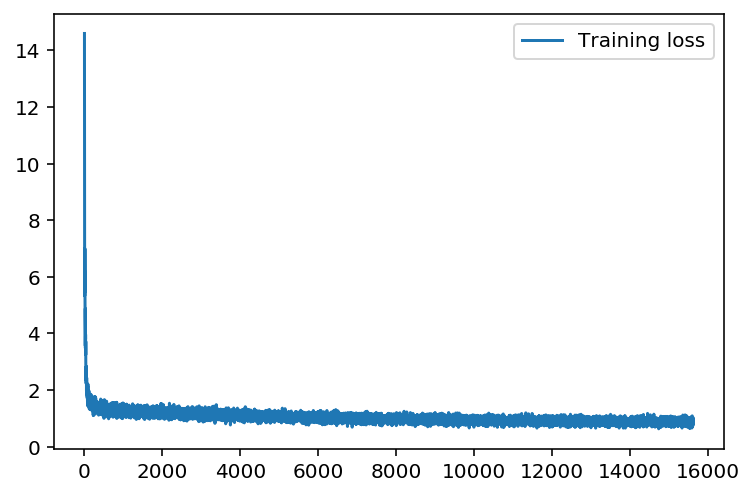

In [0]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

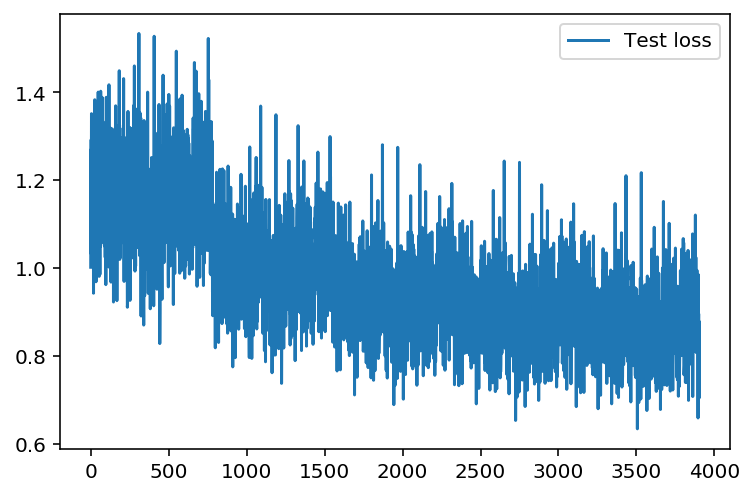

In [0]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

# Get tensor

In [0]:
#使用函数 get_tensor_by_name()从 loaded_graph 中获取tensors，后面的推荐功能要用到
def get_tensors(loaded_graph):
    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0")
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat


In [0]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')   #由于已经将模型保存在了 .meta 文件中，因此可使用tf.train.import()函数来重新创建网络
                                                                #使用别人已经训练好的模型来fine-tuning的第一步：此为创建网络Create the network
        loader.restore(sess, load_dir)                          #第二步：加载参数Load the parameters，调用restore函数来恢复网络的参数
    
        # Get Tensors from loaded model
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
    
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  #x.take(6,1)
              movie_titles: titles,  #x.take(5,1)
              dropout_keep_prob: 1}
    
        # Get Prediction
        inference_val = sess.run([inference], feed)  
    
        return (inference_val)

In [0]:
rating_movie(234, 1401)

INFO:tensorflow:Restoring parameters from ./save


[array([[3.672011]], dtype=float32)]

In [0]:
loaded_graph = tf.Graph()  #1、新建一个在这段代码中的graph
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #2、在session中引入这个图
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    # 要恢复这个网络，不仅需要恢复图（graph）和权重，也需要准备一个新的feed_dict，将新的训练数据喂给网络。
    #我们可以通过使用graph.get_tensor_by_name()方法来获得已经保存的操作（operations）和placeholder variables。
    #为后续feed做准备
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)

        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)

        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  #x.take(6,1)
            movie_titles: titles,  #x.take(5,1)
            dropout_keep_prob: 1}

        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)    #执行整个movie结构中的最后一个功能,完成全部的数据流动,得到输出的电影特征
        movie_matrics.append(movie_combine_layer_flat_val)  #为每个movie生成一个电影特征矩阵，存储到movie_matrics列表中

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [0]:
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

# user matrix

In [0]:
#将训练好的用户特征组合成用户特征矩阵并保存到本地
loaded_graph = tf.Graph()  # #1、新建一个graph
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:

        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}

        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [0]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

# recommendation

In [0]:
#使用生产的用户特征矩阵和电影特征矩阵做电影推荐

# 1、推荐同类型的电影
# 思路是计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个
#这里加了些随机选择在里面，保证每次的推荐稍稍有些不同。
def recommend_same_type_movie(movie_id_val, top_k = 20):
    
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
                            #movie_matrics显示为 (3883, 200)
                            #array([[-0.9784413 ,  0.97033578, -0.99996817, ..., -0.94367135,0.938721  ,  0.94092846],...])
 
                            #tf.square()是对a里的每一个元素求平方i=(x,y)
                            #tf.reduce_sum,注意参数表示在维度1(列)上进行求和,且维度不变 x^2+y^2
                            #tf.sqrt计算x元素的平方根
                            #这里完成向量单位化
                            #(3883, 1
        normalized_movie_matrics = movie_matrics / norm_movie_matrics

        #推荐同类型的电影
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200]) #用户输入已看过的电影，进行movieid2idx数字转化
                                                                                        #movie_matrics[转化后的标记数值]得到对应的电影特征向量
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))  #即得到输入的电影与各个电影的余弦相似性的值
                                                                                              #(1,200)×(200,3883)
        sim = (probs_similarity.eval())
        #转化为字符串
        #sim [[ 13.49374485  13.48943233  13.51107979 ...,  13.50281906  13.49236774  13.49707603]]
 
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
        print("您看的电影是：{}".format(movies_orig[[movie_id_val]]))    #movies_orig原始未处理的电影数据，为输出用户可读
        print("以下是给您的推荐：")
        p = np.squeeze(sim)   #np.squeeze将表示向量的数组转换为秩为1的数组
        p[np.argsort(p)[:-top_k]] = 0     #numpy.argsort()
                                      #x=np.array([1,4,3,-1,6,9])
                                      #函数含义：首先将p中的元素从小到大排列后，得到[-1,1,3,4,6,9]
                                      #          按照所得的排好序的对应找其在原x中的索引值，如-1由x[3]得到；1由x[0]得到，所以索引值为[3,0,2,1,4,5]
                                      #          所以这个即为输出
                                      #np.argsort()[:-top_k]表示将np.argsort()得到的结果去掉后面20个后的前面所有值为0，因为我们只考虑最相似的20个
                                      #这些值不为0，以便做后面的处理
        p = p / np.sum(p)   #sum函数对某一维度求和，这里表示全部元素求和,这里将p的值限制在0~1
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]     #参数意思分别 是从a 中以概率P，随机选择3个,
                                                  #p没有指定的时候表示同等概率会被取出，p指定时表示每个数会被取出的概率
                                                  #replace代表的意思是抽样之后不放回，选出的三个数都不一样
                                                  #a1 = np.random.choice(a=5, size=3, replace=False, p=None)
            results.add(c)        #results本身为set（可以完成剔除掉相同的推荐，虽然前面np.random.choice是不放回）
        for val in (results):
            print(val)      #由于前面已经转换为字符串eval，所以可以直接输出
            print(movies_orig[val])
        
        return results

In [0]:
recommend_same_type_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
864
[875 'Nothing to Lose (1994)' 'Drama']
2570
[2639 'Mommie Dearest (1981)' 'Drama']
2859
[2928 "Razor's Edge, The (1984)" 'Drama']
945
[957 'Scarlet Letter, The (1926)' 'Drama']
371
[375 'Safe Passage (1994)' 'Drama']


{371, 864, 945, 2570, 2859}

In [0]:
#2、推荐您喜欢的电影
#思路是使用用户特征向量与电影特征矩阵计算所有电影的评分，取评分最高的top_k个，同样加了些随机选择

def recommend_your_favorite_movie(user_id_val, top_k = 10):

    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        #推荐您喜欢的电影
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])   #！！！这里变成用户特征，且前面没有余弦相似性的计算

        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))   #这里计算后的结果就是预测分数，相当于模型中计算inference 
        sim = (probs_similarity.eval())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])

        return results

In [0]:
recommend_your_favorite_movie(234, 10)

INFO:tensorflow:Restoring parameters from ./save
以下是给您的推荐：
900
[912 'Casablanca (1942)' 'Drama|Romance|War']
1674
[1723 'Twisted (1996)' 'Comedy|Drama']
3124
[3193 'Creature (1999)' 'Documentary']
1244
[1264 'Diva (1981)' 'Action|Drama|Mystery|Romance|Thriller']
735
[745 'Close Shave, A (1995)' 'Animation|Comedy|Thriller']


{735, 900, 1244, 1674, 3124}

In [0]:
#3、看过这个电影的人还看了（喜欢）哪些电影
 #首先选出喜欢某个电影的top_k个人，得到这几个人的用户特征向量。
 #然后计算这几个人对所有电影的评分
 #选择每个人评分最高的电影作为推荐
 #同样加入了随机选择

import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])   #根据输入的电影得到这个电影的特征向量
        probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]        #选出喜欢某个电影的top_k个人
    #     print(normalized_users_matrics.eval().shape)
    #     print(probs_user_favorite_similarity.eval()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
        print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
        probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])   #计算这几个人的特征
        probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
    
    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
        p = np.argmax(sim, 1)
        print("喜欢看这个电影的人还喜欢看：")

        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [0]:
recommend_other_favorite_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
喜欢看这个电影的人是：[[4814 'M' 18 14 '80526']
 [2851 'F' 25 7 '94107']
 [985 'M' 25 4 '32608']
 [899 'F' 25 1 '30605']
 [900 'F' 56 13 '90066']
 [1763 'M' 35 7 '76248']
 [5214 'F' 35 9 '07452']
 [3095 'F' 25 3 '06810']
 [100 'M' 35 17 '95401']
 [4085 'F' 25 6 '79416']
 [3150 'F' 25 3 '92831']
 [5055 'F' 35 16 '97330']
 [5861 'F' 50 1 '98499']
 [4142 'M' 56 7 '01040']
 [3676 'F' 35 12 '48109']
 [3031 'M' 18 4 '48135']
 [2391 'M' 50 18 '13126']
 [371 'M' 18 4 '02141']
 [2338 'M' 45 17 '13152']
 [5767 'M' 25 2 '75287']]
喜欢看这个电影的人还喜欢看：
